# A triaxial experiment with Cam-clay yield criterion

In this notebook, we will simulate a triaxial experiment in hardening plasticity with a Cam-clay yield criterion. In contrast to the previous 1D example, now some variables will be tensorial while others will be scalar. We will see, however, that this is in practice of little importance from an implementation point of view. \
We will start by re-using the previous **Mandel** notation for tensors: 2nd order tensors will become vectors and 4th order tensors will become matrices. The main novelty from 1D resides in the yield criterion and flow rule, which are much more complex to calculte than in the 1D case. \
The Cam-clay yield criterion reads:

$$
f(p,q) = q^2 + M^2(p+p_t)(p-p_c),
$$

where $p=\frac{1}{3}\mathrm{tr}({\bf \sigma})$ is the mean stress and $q=\sqrt{\frac{3}{2}{\bf \sigma}^d:{\bf \sigma}^d}$ is the *Von Mises* stress of the *deviatoric stress* tensor ${\bf \sigma}^d$. \
Recalling that if $\bf T$ is a second order tensor and $\bf \tilde{T}$ it's Mandel notation, then ${\bf T}:{\bf T} = {\bf\tilde{T}}\cdot{\bf\tilde{T}}$, let us implement the yield criterion in the Mandel notation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utilities to translate to/from Mandel notation for 2nd order symmetric tensors
def mandel_to_tensor2(T):
    assert T.shape==(6,)
    return np.array([[T[0], T[5]/np.sqrt(2), T[4]/np.sqrt(2)],
                     [T[5]/np.sqrt(2), T[1], T[3]/np.sqrt(2)],
                     [T[4]/np.sqrt(2), T[3]/np.sqrt(2), T[2]]])
    
def tensor2_to_mandel(T):
    assert T.shape==(3,3)
    assert T[0,1]==T[1,0] and T[0,2]==T[2,0] and T[1,2]==T[2,1]
    return np.array([T[0,0], T[1,1], T[2,2], np.sqrt(2)*T[1,2], np.sqrt(2)*T[0,2], np.sqrt(2)*T[0,1]])

def lame(E, nu):
    return E*nu/((1+nu)*(1-2*nu)), E/2/(1+nu)

def stiffness_tensor(lam, mu):
    D = np.zeros((6,6))
    for i in range(3):
        for j in range(3):
            D[i,j]+=lam
    for i in range(6):
        D[i,i]+=2*mu
    return D

# Second order identity tensor in Mandel notation
I2 = np.array([1,1,1,0,0,0]) 

# Trace and Deviator function
def tr(T):
    assert T.shape==(6,)
    return np.sum(T[0:3])
    
def dev(T):
    assert T.shape==(6,)
    return T - 1/3*tr(T)*I2

def yield_function(sigma, pc, pt, M): #Sigma in mandel notation
    p = 1/3*tr(sigma)
    sig_d = dev(sigma)
    q = np.sqrt(1.5 * np.dot(sig_d, sig_d))
    return q**2 + M**2 * (p+pt)*(p-pc)

Now is the flow rule. If we take associated plasticity, the plastic potential is equal to the yield criterion ($g=f$), and the flow rule is:

$$
{\bf \dot\varepsilon}_p = \dot\lambda \frac{\partial g}{\partial{\bf\sigma}},
$$

where the scalar $\lambda$ is the plastic multiplier. The tensor ${\bf n} = \frac{\partial g}{\partial{\bf\sigma}}$ representing the direction of plastic flow is not an easy one to calculate. We will decompose it as such:

$$
\frac{\partial g}{\partial{\bf\sigma}} = \frac{\partial g}{\partial p}\frac{\partial p}{\partial{\bf\sigma}} + \frac{\partial g}{\partial q}\frac{\partial q}{\partial{\bf\sigma}}.
$$

Partial derivatives with respect to $p$ and $q$ are fairly trivial:

$$
\begin{align}
\frac{\partial g}{\partial p} &= M^2  (2p + p_t -p_c), \\
\frac{\partial g}{\partial q} &= 2q,
\end{align}
$$

but the other two partial derivatives require derivation with respect to a tensor variable. $\partial h/\partial {\bf T}$ is in general the tensor $\bf S$ so that $\mathrm{d}h = {\bf S}:\mathrm{d}{\bf T}$ (other variables being kept constant). We have:

$$
\begin{array}
\mathrm{d}p = \frac{1}{3}(\mathrm{d}\sigma_{11}+\mathrm{d}\sigma_{22}+\mathrm{d}\sigma_{33}) = \frac{1}{3}{\bf I}_2:\mathrm{d}{\bf \sigma} \ \rightarrow \ \frac{\partial p}{\partial{\bf\sigma}} = \frac{1}{3}{\bf I}_2,\\
\frac{\partial q}{\partial{\bf\sigma}} = \frac{\partial}{\partial{\bf\sigma}}\left( \sqrt{\frac{3}{2}{\bf\sigma}^d:{\bf\sigma}^d}\right) = \frac{6{\bf\sigma}^d}{4\sqrt{\frac{3}{2}{\bf\sigma}^d:{\bf\sigma}^d}} = \frac{3{\bf\sigma}^d}{2q}.
\end{array}
$$

In fine, the plastic flow direction is:

$$
{\bf n} = \frac{M^2}{3}(2p + p_t -p_c){\bf I}_2 + 3{\bf\sigma}^d.
$$

Let us implement it.

In [2]:
# Function which returns the plastic flow direction tensor n
def flow_direction(sigma, pc, pt, M):
    p = tr(sigma)/3.0
    n = M**2/3*(2*p+pt-pc)*I2 + 3*dev(sigma)
    return n / np.sqrt(np.dot(n,n)) # normalized n tensor

We now have to implement the plasticity return mapping, namely the equation system $\bf F$ as well as the jacobian $\bf J$. The jacobian can be calculated analytically but is tedious to obtain: we will make use here of a numerical jacobian.

In [3]:
# Implicit system
def F(dX, sig_n, rpc_n, M, ft, deps, C, h):
    deps_el = dX[:6]
    dlam = dX[6]
    drpc = dX[7]
    sig_ = sig_n + np.dot(C, deps_el)
    rpc_ = rpc_n + drpc
    pc_ = E * rpc_
    pt_ = ft*pc_
    n = flow_direction(sig_, pc_, pt_, M)
    return np.array([*(deps_el + dlam*n - deps),
                     yield_function(sig_, pc_, pt_, M)/E/pc0,
                     (drpc + h*dlam*tr(n)*rpc_)])

# Numerical jacobian
def numerical_J(dX, residu, perturbation):
    perturbator = np.diag(perturbation*np.ones(len(dX)))
    return 1/(2*perturbation)*np.array([residu(dX + eps)-residu(dX - eps) for eps in perturbator]).T

def newton_method(residu, jacobian, initial_guess, tolerance, max_iteration=50):
    X_n = initial_guess
    iteration = 0
    while np.linalg.norm(residu(X_n)) > tolerance and iteration < max_iteration:
        X_n -= np.dot(np.linalg.inv(jacobian(X_n)), residu(X_n))
        iteration += 1
    if np.linalg.norm(residu(X_n)) > tolerance:  # Not converged
        print("Did not converge after {} iterations.".format(iteration))
    else:
        print("Newton solver: converged after {} iterations.".format(iteration))   
    return X_n

In [4]:
# Material properties
E = 1e10
nu = 0.2
pc0 = -1e6
h = 3000.0
ft = 0.1
M = 1

C = stiffness_tensor(*lame(E,nu))

# Load step
deps = tensor2_to_mandel(np.diag(-1e-6*np.ones(3)))

# Initial values
eps = [np.zeros(6)]
eps_el = [np.zeros(6)]
sig = [np.zeros(6)]
lam = [0.0]
pc = [pc0]

def integrator(eps, deps, eps_el, lam, pc):
    eps += deps
    sig_trial = np.dot(C, eps)
    if yield_function(sig_trial, pc, ft*pc, M) <= 0:
        eps_el += deps
        return eps, eps_el, lam, pc
    else:
        f = lambda X : F(X, np.dot(C, eps_el), pc/E, M, ft, deps, C, h)
        dX = newton_method(f, lambda X : numerical_J(X, f, 1e-9), np.zeros(8), 1e-6)
        deps_el = dX[:6]
        dlam = dX[6]
        dpc = E*dX[7]
        return eps, eps_el+deps_el, lam+dlam, pc+dpc


In [5]:
for i in range(100):
    print("Load step", i+1)
    eps_, eps_el_, lam_, pc_ = integrator(eps[-1].copy(), deps, eps_el[-1].copy(), lam[-1], pc[-1])
    eps.append(eps_.copy())
    eps_el.append(eps_el_)
    lam.append(lam_)
    pc.append(pc_)
    sig.append(np.dot(C,eps_el_))

Load step 1
Load step 2
Load step 3
Load step 4
Load step 5
Load step 6
Load step 7
Load step 8
Load step 9
Load step 10
Load step 11
Load step 12
Load step 13
Load step 14
Load step 15
Load step 16
Load step 17
Load step 18
Load step 19
Load step 20
Load step 21
Load step 22
Load step 23
Load step 24
Load step 25
Load step 26
Load step 27
Load step 28
Load step 29
Load step 30
Load step 31
Load step 32
Load step 33
Load step 34
Load step 35
Load step 36
Load step 37
Load step 38
Load step 39
Load step 40
Load step 41
Load step 42
Load step 43
Load step 44
Load step 45
Load step 46
Load step 47
Load step 48
Load step 49
Load step 50
Load step 51
Load step 52
Load step 53
Load step 54
Load step 55
Load step 56
Load step 57
Load step 58
Load step 59
Load step 60
Load step 61
Newton solver: converged after 1 iterations.
Load step 62
Newton solver: converged after 1 iterations.
Load step 63
Newton solver: converged after 1 iterations.
Load step 64
Newton solver: converged after 1 iteration

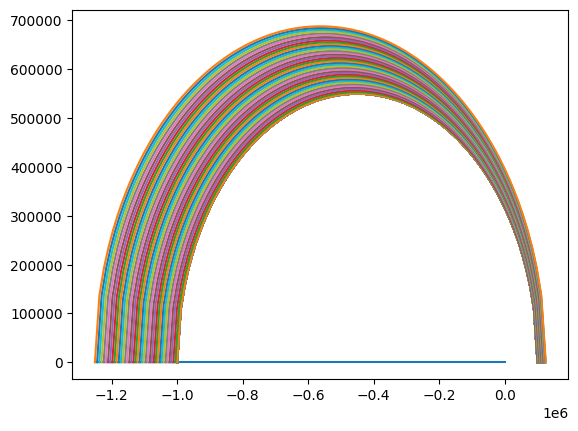

In [6]:
plt.plot([tr(sigma)/3 for sigma in sig], [np.sqrt(1.5 * np.dot(dev(sigma), dev(sigma))) for sigma in sig])
def yield_surf(p, pc, M, ft):
    return M**2 * np.sqrt((p+ft*pc)*(pc-p))
for pc_ in pc:
    P = np.linspace(pc_, -ft*pc_, 100)
    ys = lambda p : yield_surf(p, pc_, M, ft)
    plt.plot(P, [ys(p) for p in P])

In [7]:
eps1 = eps.copy()
eps_el1 = eps_el.copy()
sig1 = sig.copy()

## Stress - strain hybrid control

In [8]:
# Material properties
E = 1.5e11
nu = 0.3
pc0 = -30e6
h = 250.0
ft = 0.1
M = 1.5

C = stiffness_tensor(*lame(E,nu))

# Load step
deps_all = [np.zeros(6), *[np.array([0.0,0.0,0.0,0.0,0.0,np.sqrt(2)*2e-5]) for i in range(10)]]
#deps_all = [ np.zeros(6) for i in range(100) ]
#dsig_all = np.diff(sig, axis=0).copy()
dsig_all = [np.array([-7.5e6, -7.5e6, -7.5e6, 0.0, 0.0, 0.0]), *[np.zeros(6) for i in range(10)]]

sig_tol = abs(np.linalg.norm(dsig_all[0])/1e8)

# Initial values
eps = [np.zeros(6)]
eps_el = [np.zeros(6)]
sig = [np.zeros(6)]
lam = [0.0]
pc = [pc0]

I4 = np.diag(np.ones(6))

def integrator_with_tangent(eps, deps, eps_el, lam, pc):
    eps += deps.copy()
    sig_trial = np.dot(C, eps)
    if yield_function(sig_trial, pc, ft*pc, M) <= 0:
        eps_el += deps.copy()
        return eps, eps_el, lam, pc, C
    else:
        f = lambda X : F(X, np.dot(C, eps_el), pc/E, M, ft, deps, C, h)
        dX = newton_method(f, lambda X : numerical_J(X, f, 1e-10), np.zeros(8), 1e-15)
        deps_el = dX[:6].copy()
        dlam = dX[6].copy()
        dpc = E*dX[7].copy()
        jacobian = numerical_J(dX, lambda X : F(X, np.dot(C, eps_el+deps_el), (pc+dpc)/E, M, ft, deps, C, h), 1e-10)
        j_inv_eps_el = np.linalg.inv(jacobian)[:6,:6].copy()
        dsig_ddeps = np.dot( C, j_inv_eps_el ).copy()
        return eps, eps_el+deps_el, lam+dlam, pc+dpc, dsig_ddeps

for i in range(len(deps_all)):
    print("Load step", i+1)
    sig_ = sig[-1].copy()
    sig_goal = sig_.copy() + dsig_all[i].copy()
    deps = deps_all[i].copy()
    eps_, eps_el_, lam_, pc_, dsig_ddeps = integrator_with_tangent(eps[-1].copy(), deps.copy(), eps_el[-1].copy(), lam[-1], pc[-1])
    sig_ = np.dot(C, eps_el_).copy()
    #print("deps:",deps)
    j=0
    while np.linalg.norm(sig_goal[:3]-sig_[:3]) > 1e-3:
        j+=1
        eps_, eps_el_, lam_, pc_, dsig_ddeps = integrator_with_tangent(eps[-1].copy(), deps.copy(), eps_el[-1].copy(), lam[-1], pc[-1])
        sig_ = np.dot(C, eps_el_).copy()
        #print(i,"sig_:",sig_)
        #print(i,"sig_goal:",sig_goal)
        print(i, "C:",C)
        print(i, "dsig_ddeps:", dsig_ddeps)
        deps[:3] += np.dot(np.linalg.inv(dsig_ddeps)[:3,:3],(sig_goal-sig_)[:3]).copy()
        #print("Current epsilon")
        #print( eps[-1]+deps )
        #print("deps:",deps)
        if j>30:
            raise RuntimeError("Too many iterations")
    print(i, "sig_:", sig_)
    eps.append(eps_.copy())
    eps_el.append(eps_el_.copy())
    lam.append(lam_)
    pc.append(pc_)
    sig.append(np.dot(C,eps_el_).copy())

Load step 1
0 C: [[2.01923077e+11 8.65384615e+10 8.65384615e+10 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.65384615e+10 2.01923077e+11 8.65384615e+10 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.65384615e+10 8.65384615e+10 2.01923077e+11 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.15384615e+11
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.15384615e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.15384615e+11]]
0 dsig_ddeps: [[2.01923077e+11 8.65384615e+10 8.65384615e+10 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.65384615e+10 2.01923077e+11 8.65384615e+10 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.65384615e+10 8.65384615e+10 2.01923077e+11 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.15384615e+11
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0

RuntimeError: Too many iterations

In [ ]:
plt.plot([tr(sigma)/3 for sigma in sig], [np.sqrt(1.5 * np.dot(dev(sigma), dev(sigma))) for sigma in sig])
def yield_surf(p, pc, M, ft):
    return M**2 * np.sqrt((p+ft*pc)*(pc-p))
for pc_ in pc:
    P = np.linspace(pc_, -ft*pc_, 100)
    ys = lambda p : yield_surf(p, pc_, M, ft)
    plt.plot(P, [ys(p) for p in P])

In [ ]:
eps

In [ ]:
eps1

In [10]:
sig

[array([0., 0., 0., 0., 0., 0.]),
 array([-7500000., -7500000., -7500000.,        0.,        0.,        0.]),
 array([-7500000.        , -7500000.        , -7500000.        ,
               0.        ,        0.        ,  3263569.75932253]),
 array([-7500000.        , -7500000.        , -7500000.        ,
               0.        ,        0.        ,  6527139.51864506]),
 array([-7500000.        , -7500000.        , -7500000.        ,
               0.        ,        0.        ,  9790709.27796758]),
 array([-7500000.        , -7500000.        , -7500000.        ,
               0.        ,        0.        , 13054279.03729011]),
 array([-7500000.        , -7500000.        , -7500000.        ,
               0.        ,        0.        , 16317848.79661264])]

In [14]:
sig1

[array([0., 0., 0., 0., 0., 0.]),
 array([-50000., -50000., -50000.,      0.,      0.,      0.]),
 array([-100000., -100000., -100000.,       0.,       0.,       0.]),
 array([-150000., -150000., -150000.,       0.,       0.,       0.]),
 array([-200000., -200000., -200000.,       0.,       0.,       0.]),
 array([-250000., -250000., -250000.,       0.,       0.,       0.]),
 array([-300000., -300000., -300000.,       0.,       0.,       0.]),
 array([-350000., -350000., -350000.,       0.,       0.,       0.]),
 array([-400000., -400000., -400000.,       0.,       0.,       0.]),
 array([-450000., -450000., -450000.,       0.,       0.,       0.]),
 array([-500000., -500000., -500000.,       0.,       0.,       0.]),
 array([-550000., -550000., -550000.,       0.,       0.,       0.]),
 array([-600000., -600000., -600000.,       0.,       0.,       0.]),
 array([-650000., -650000., -650000.,       0.,       0.,       0.]),
 array([-700000., -700000., -700000.,       0.,       0.,     

In [150]:
eps_el

[array([-3.e-06, -3.e-06, -3.e-06,  0.e+00,  0.e+00,  0.e+00]),
 array([-6.e-06, -6.e-06, -6.e-06,  0.e+00,  0.e+00,  0.e+00]),
 array([-9.e-06, -9.e-06, -9.e-06,  0.e+00,  0.e+00,  0.e+00]),
 array([-1.2e-05, -1.2e-05, -1.2e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-1.5e-05, -1.5e-05, -1.5e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-1.8e-05, -1.8e-05, -1.8e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-2.1e-05, -2.1e-05, -2.1e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-2.4e-05, -2.4e-05, -2.4e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-2.7e-05, -2.7e-05, -2.7e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-3.e-05, -3.e-05, -3.e-05,  0.e+00,  0.e+00,  0.e+00]),
 array([-3.3e-05, -3.3e-05, -3.3e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-3.6e-05, -3.6e-05, -3.6e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-3.9e-05, -3.9e-05, -3.9e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-4.2e-05, -4.2e-05, -4.2e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-4.5e-05, -4.5e-05, -4.5e-05,  0.0e+

In [151]:
eps_el1

[array([0., 0., 0., 0., 0., 0.]),
 array([-3.e-06, -3.e-06, -3.e-06,  0.e+00,  0.e+00,  0.e+00]),
 array([-6.e-06, -6.e-06, -6.e-06,  0.e+00,  0.e+00,  0.e+00]),
 array([-9.e-06, -9.e-06, -9.e-06,  0.e+00,  0.e+00,  0.e+00]),
 array([-1.2e-05, -1.2e-05, -1.2e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-1.5e-05, -1.5e-05, -1.5e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-1.8e-05, -1.8e-05, -1.8e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-2.1e-05, -2.1e-05, -2.1e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-2.4e-05, -2.4e-05, -2.4e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-2.7e-05, -2.7e-05, -2.7e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-3.e-05, -3.e-05, -3.e-05,  0.e+00,  0.e+00,  0.e+00]),
 array([-3.3e-05, -3.3e-05, -3.3e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-3.6e-05, -3.6e-05, -3.6e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-3.9e-05, -3.9e-05, -3.9e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-4.2e-05, -4.2e-05, -4.2e-05,  0.0e+00,  0.0e+00,  0.0e+00]),
 array([-4